In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
from pathlib import Path
import anndata as ad
import scanpy as sc
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from matplotlib import pyplot as plt
import time

sys.path.insert(0, "/home/ylu/project/Benchmark_alignment_methods/scripts/methods")
from my_STAlign import stalign_align
sys.path.insert(0, "/home/ylu/project")
from utils import *
sys.path.insert(0, "/home/ylu/project/STalign")
from STalign import STalign

%load_ext autoreload
%autoreload 2

In [4]:
# Load DLPFC data
data_folder = "../../data/STARMapPlus/"
results_folder = "./partial_results/"
cache_folder = os.path.join(results_folder, 'Scube_outputs')
Path(cache_folder).mkdir(parents=True, exist_ok=True)

# adata_names = 'sagittal2'
adata_names = 'well_08'
        
adata = ad.read_h5ad(os.path.join(data_folder,"{}.h5ad".format(adata_names)))
scale = np.linalg.norm(adata.obsm['spatial'].max(0) - adata.obsm['spatial'].min(0))

In [5]:
# split into slices
slices = split_slice(
    adata=adata,
    spatial_key='spatial_raw',
    split_num=15,
    axis=2,
)[:-1]
interval = len(slices) // 2
        
# Evaluate SPACEL
overlay_ratios = np.linspace(0.3, 1, 8)
alignment_accuracy_results = []

In [5]:
slices[0]

AnnData object with n_obs × n_vars = 8255 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
    obsm: 'spatial', 'spatial_raw'

In [17]:
i = 0
slice1 = slices[i].copy()
slice2 = slices[i+1].copy()
slice1_crop, slice2_crop = crop_slices(
    slice1, 
    slice2, 
    spatial_key='spatial', 
    overlay_ratio = 0.6,
)

In [18]:
slice1_crop.obsm['spatial_rot'] = slice1_crop.obsm['spatial'].copy()
rigid_transformation(slice2_crop, spatial_key, 'spatial_rot')

AnnData object with n_obs × n_vars = 8255 × 1022
    obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'slice'
    obsm: 'spatial', 'spatial_raw', 'spatial_rot'

In [18]:
key_added = 'align_spatial'
spatial_key = 'spatial'
anno_key = 'Main_molecular_tissue_region'

0 of 8255
8254 of 8255


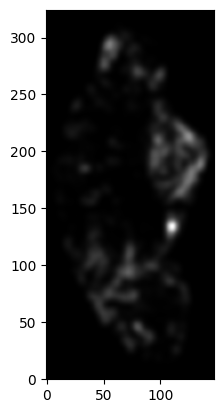

In [19]:
factor = 0.13
xI = slice1.obsm[spatial_key][:,0] * factor
yI = slice1.obsm[spatial_key][:,1] * factor
xJ = slice2.obsm[spatial_key][:,0] * factor
yJ = slice2.obsm[spatial_key][:,1] * factor
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=30,blur=1.5)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

In [20]:
align_slices = stalign_align(
    models = [slice1_crop, slice2_crop],
    spatial_key = 'spatial',
    key_added = key_added,
    device = "cuda:0",
    scale=0.13,
    zero_mean=False,
)

/home/ylu/anaconda3/envs/STAlign/lib/python3.9/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


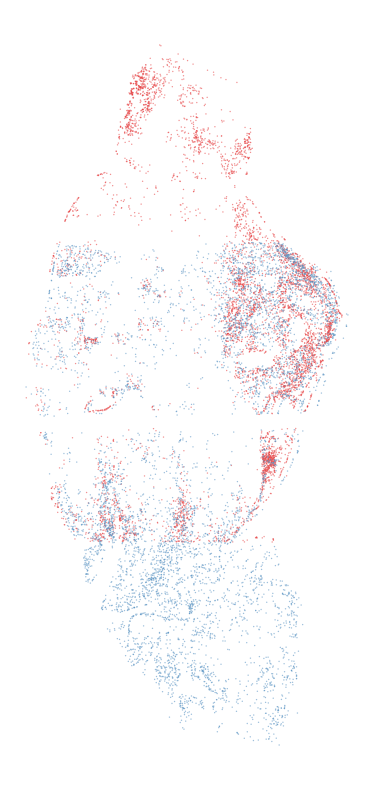

In [21]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_overlay(
    align_slices, 
    key_added,
    ax,
    point_size=1,
    label_key=None,
    palette = "Set1",
    title = '',
    legend=False,
    fontsize=8,
)
plt.show()

In [22]:
align_spatial = align_slices[1].obsm[key_added]
spatial_GT = align_slices[1].obsm["spatial"]

# calculate the metrics
mae, mae_var = MAE(align_spatial / scale, spatial_GT / scale)
mse, mse_var = MSE(align_spatial / scale, spatial_GT / scale)
print(mae)

0.006353371839159598


In [6]:
key_added = 'align_spatial'
spatial_key = 'spatial'
anno_key = 'Main_molecular_tissue_region'

for i in range(interval):
    slice1 = slices[i].copy()
    slice2 = slices[i+interval].copy()
    for overlay_ratio in overlay_ratios:
        slice1_crop, slice2_crop = crop_slices(
            slice1, 
            slice2, 
            spatial_key='spatial', 
            overlay_ratio = overlay_ratio,
        )
        slice1_crop.obsm['spatial_rot'] = slice1_crop.obsm['spatial'].copy()
        rigid_transformation(slice2_crop, spatial_key, 'spatial_rot')
        # slice1_crop.obsm['spatial_ori'] = slice1_crop.obsm['spatial'].copy()
        # slice2_crop.obsm['spatial_ori'] = slice2_crop.obsm['spatial'].copy()
        # slice1_crop.obsm['spatial'] = slice1_crop.obsm['spatial_rot'].copy()
        # slice2_crop.obsm['spatial'] = slice2_crop.obsm['spatial_rot'].copy()
        # align_slices = [slice1_crop, slice2_crop]
        # align slices
        align_slices = stalign_align(
            models = [slice1_crop, slice2_crop],
            spatial_key = 'spatial_rot',
            key_added = key_added,
            device = "cuda:0",
            # scale=0.13,
            scale=0.3,
            zero_mean=True,
        )
        
        align_spatial = align_slices[1].obsm[key_added]
        spatial_GT = align_slices[1].obsm["spatial"]
        
        # calculate the metrics
        mae, mae_var = MAE(align_spatial / scale, spatial_GT / scale)
        mse, mse_var = MSE(align_spatial / scale, spatial_GT / scale)
        print(mae)
        alignment_accuracy_results.append([mae, mae_var, mse, mse_var, overlay_ratio])

# save the results
np.save(os.path.join(results_folder,'STARMap_{}_STAlign_wo_prealign_partial_results.npy'.format(adata_names)), alignment_accuracy_results, allow_pickle=True)

/home/ylu/project/STalign/STalign/STalign.py:1044: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/home/ylu/project/STalign/STalign/STalign.py:1045: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/home/ylu/anaconda3/envs/STAlign/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0.46309340852370784


/home/ylu/anaconda3/envs/STAlign/lib/python3.9/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


0.4445084728196189
0.2465125095095801
0.3665294352603926
0.32627620223268605
0.19384305986580103
0.32536151250262374
0.24637135270516677
0.44687052028075613
0.4012518694977383
0.20193220061857242
0.42291851974619327
0.4605754304694425
0.4073515796358643
0.10796532096203791
0.19660232157083896
0.3404604931388006
0.2055510662421695
0.21295802778263387
0.46749206409540595
0.4762903630051832
0.12154407204646471
0.28328766596420585
0.47426824233329284
0.4416669888229926
0.2496440225752352
0.4107875123202377
0.43137048282927626
0.1459761451271976
0.4274488571978746
0.3290602502992638
0.242766220530665
0.22834962833553482
0.42502396481840105
0.1907160691585567
0.17008235392085153
0.3337647808881669
0.46800682378083575
0.5172884389977309
0.535962387828936
0.25833155625058873
0.47202758997081423
0.36924859480021266
0.3908997954316353
0.4771701924626795
0.2037879723169567
0.2584834593909313
0.5484708434858037
0.23356266110100604
0.49327685885811295
0.3440662126526555
0.4863560427195548
0.2656505